# Notebook 08: Training more than one ML model

### Goal: Training a ML using all features/predictors/inputs and all ML methods

#### Background

So far in Notebooks 4-7 we have shown you how to train a single ML model for each task. But one really nice thing about ```sklearn``` is that they have coded up all the models we discussed in the paper to adopt the same syntax. This will make more sense in a little bit, but what this enables us to do is train many different ML methods to find which method performs best for our specific task. This generally a good method for designing your own ML projects.

### Classification, simple 
We will start off the same as Notebook 4. 

In [1]:
#needed packages 
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

#plot parameters that I personally like, feel free to make these your own.
import matplotlib
matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14 
matplotlib.rcParams['xtick.labelsize'] = 12 
matplotlib.rcParams['ytick.labelsize'] = 12 
matplotlib.rcParams['legend.fontsize'] = 12 
matplotlib.rcParams['legend.facecolor'] = 'w' 
matplotlib.rcParams['savefig.transparent'] = False

#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'

#import some helper functions for our other directory.
import sys
sys.path.insert(1, '../scripts/')
from aux_functions import load_n_combine_df
(X_train,y_train),(X_validate,y_validate),(X_test,y_test) = load_n_combine_df(path_to_data='../datasets/sevir/',features_to_keep=np.arange(0,1,1),class_labels=True)

But now we will initalize a list of models!

In [2]:
#load ML code from sklearn
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

#initialize
model_list = [LogisticRegression(),GaussianNB(),DecisionTreeClassifier(),RandomForestClassifier(),GradientBoostingClassifier(),LinearSVC(dual=False)]

print(model_list)

[LogisticRegression(), GaussianNB(), DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier(), LinearSVC(dual=False)]


since the syntax is identical, we can loop over this list and train all the methods

In [3]:
#Import a progress bar so we know how long it is taking
import tqdm 

for model in tqdm.tqdm(model_list):
    model.fit(X_train,y_train)

100%|█████████████████████████████████████████████| 6/6 [00:57<00:00,  9.65s/it]


Wait for the star to finish up above, then that means it is done training! Way to go, you just trained 6 **different** ML models. Nice right? But lets evaluate them now. 

Let's start by looking at the performance diagram first 

LgR accuracy: 81.0%
NB accuracy: 80.0%
DT accuracy: 80.0%
RF accuracy: 80.0%
GBT accuracy: 80.0%
SVM accuracy: 81.0%


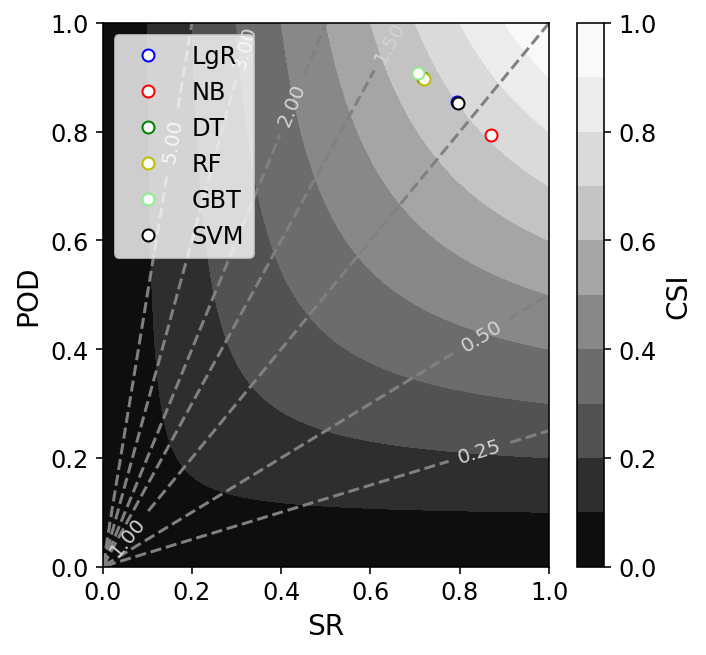

In [5]:
#load contingency_table func
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod

#make axis to plot on 
ax = make_performance_diagram_axis()

#make list of colors so each method shows up as a different color
colors=['b','r','g','y','LightGreen','k']
legend_labels = ['LgR','NB','DT','RF','GBT','SVM']

#loop over all trained models 
for idx,model in enumerate(model_list):
    #get predictions 
    yhat = model.predict(X_validate)
    #the contingency table calculator expects y_true,y_pred
    cont_table = get_contingency_table(y_validate,yhat)
    
    #get metrics
    accuracy = get_acc(cont_table)
    pod = get_pod(cont_table)
    sr = get_sr(cont_table)
    csi = csi_from_sr_and_pod(sr,pod)
    
    ax.plot(sr,pod,'o',color=colors[idx],markerfacecolor='w',label=legend_labels[idx])
    
    print('{} accuracy: {}%'.format(legend_labels[idx],np.round(accuracy,0)))
    
ax.legend()

As shown in the paper, all of the methods basically have the same results with some minor differences. If we look at the AUC of the ROC curve we will see something similar. Just one note though, the SVM method we used here (LinearSVC) does not support ```model.predict_proba```, so we will leave it off here. 

LgR AUC: 0.9
NB AUC: 0.9
DT AUC: 0.9
RF AUC: 0.9
GBT AUC: 0.9


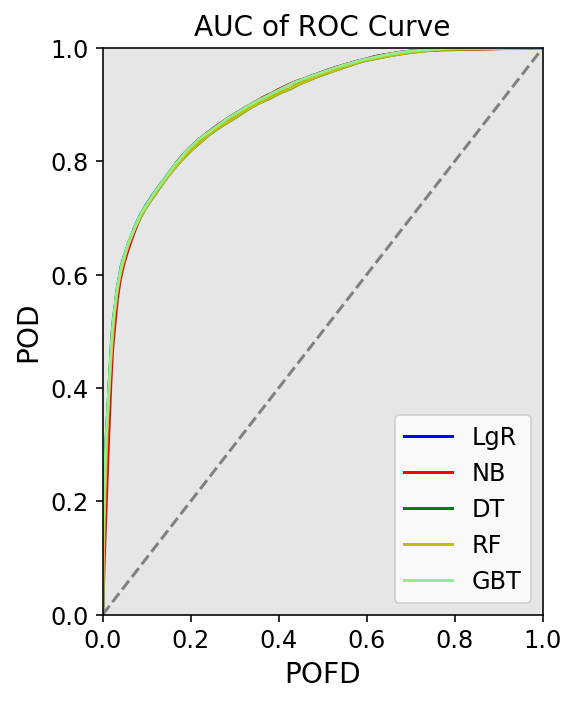

In [6]:
#load contingency_table func
from gewitter_functions import get_points_in_roc_curve,get_area_under_roc_curve

#something to help with annotating the figure
import matplotlib.patheffects as path_effects
pe = [path_effects.withStroke(linewidth=2,
                             foreground="k")]
pe2 = [path_effects.withStroke(linewidth=2,
                             foreground="w")]
    
#make figure
fig = plt.figure(figsize=(4.1,5))
#set facecolor to white so you can copy/paste the image somewhere 
fig.set_facecolor('w')

#make list of colors so each method shows up as a different color
colors=['b','r','g','y','LightGreen','k']
legend_labels = ['LgR','NB','DT','RF','GBT','SVM']

ax = plt.gca()

#loop over all trained models 
for idx,model in enumerate(model_list[:-1]):
    #get predictions 
    yhat_proba = model.predict_proba(X_validate)
    
    #lets just focus on the output from class 1 (note, the sum of these two columns should be 1)
    y_preds = yhat_proba[:,1]
    
    #get the roc curve
    pofds, pods = get_points_in_roc_curve(forecast_probabilities=y_preds, observed_labels=y_validate, threshold_arg=np.linspace(0,1,100))
    
    #get AUC 
    auc = get_area_under_roc_curve(pofds,pods)
    
    ax.plot(pofds,pods,'-',color=colors[idx],label=legend_labels[idx])
    
    print('{} AUC: {}'.format(legend_labels[idx],np.round(auc,2)))
    
ax.legend()

#set some limits
ax.set_xlim([0,1])
ax.set_ylim([0,1])

#set the no-skill line
ax.plot([0,1],[0,1],'--',color='Grey')

#label things
ax.set_title("AUC of ROC Curve")
ax.set_xlabel('POFD')
ax.set_ylabel('POD')

plt.tight_layout()

Congrats, you have now trained and evaluated multiple models with the same data! I encourage you to go ahead and now code up how to do it with all the data as inputs. Please note, it does take a bit longer to train, but shouldn't take more than 5-10 mins.

### Regression, simple 
We will start off the same as Notebook 5.

In [7]:
#needed packages 
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

#plot parameters that I personally like, feel free to make these your own.
import matplotlib
matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14 
matplotlib.rcParams['xtick.labelsize'] = 12 
matplotlib.rcParams['ytick.labelsize'] = 12 
matplotlib.rcParams['legend.fontsize'] = 12 
matplotlib.rcParams['legend.facecolor'] = 'w' 
matplotlib.rcParams['savefig.transparent'] = False

#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'

#import some helper functions for our other directory.
import sys
sys.path.insert(1, '../scripts/')
from aux_functions import load_n_combine_df
(X_train,y_train),(X_validate,y_validate),(X_test,y_test) = load_n_combine_df(path_to_data='../datasets/sevir/',features_to_keep=np.arange(0,1,1),class_labels=False,dropzeros=True)

Now we will initalize a list of *Regression* models

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR

#initialize
model_list = [LinearRegression(),DecisionTreeRegressor(),RandomForestRegressor(),GradientBoostingRegressor(),LinearSVR()]

print(model_list)

[LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(), GradientBoostingRegressor(), LinearSVR()]


Now go train your ML regressors!

In [13]:
#Import a progress bar so we know how long it is taking
import tqdm 

for model in tqdm.tqdm(model_list):
    model.fit(X_train,y_train)

 80%|████████████████████████████████████         | 4/5 [00:22<00:06,  6.82s/it]/Users/randyjc2/miniconda3/envs/waf_tutorial_part1/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
100%|█████████████████████████████████████████████| 5/5 [00:30<00:00,  6.04s/it]


As before, lets evaluate them. First we will make the one-to-one scatter plot like Figures 14 and 16

n_samples= 34395.0
n_samples= 37383.0
n_samples= 37418.0
n_samples= 39484.0
n_samples= 36356.0


/var/folders/ph/fm42qdjd6vq_mxy6l2ts8sp80000gn/T/ipykernel_28106/4268494503.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


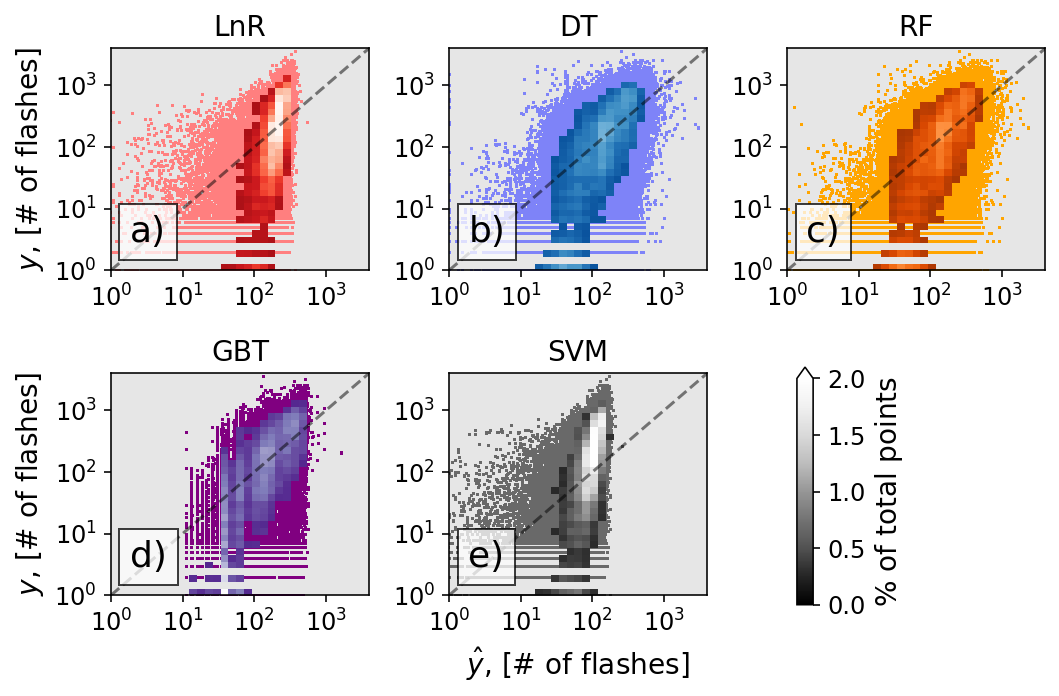

In [15]:
from aux_functions import boxbin,make_colorbar
#make figure with 2 rows and 3 columns with size 7.5" by 5"
fig,axes = plt.subplots(2,3,figsize=(7.5,5))
#set facecolor to white so we can copy paste it if you want to somewhere else
fig.set_facecolor('w')

#the number of bins for the boxbin method 
n = 33
#the bins we want in x and y 
xbins = np.logspace(0,3.5,n)
ybins = np.logspace(0,3.5,n)

#colors i like 
r = [255/255,127/255,127/255]
b = [126/255,131/255,248/255]

#labels
labels= ['LnR','DT','RF','GBT','SVM']
#color list, one for each model 
colors= [r,b,'orange','purple','dimgrey']
#colormaps to match the colors in 'theme'
cmaps=['Reds_r','Blues_r','Oranges_r','Purples_r','Greys_r']

#force ticks to show up where i want them 
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(0.1,0.2,0.4,0.6,0.8,1,2,4,6,8,10 )) 

#axes is shape [2,3], it is easier to loop if we flatten this, which is what ravel does 
axes = axes.ravel()

#some parameters to make it pretty 
c_scale = 0.575
fs3 = 11
fs4 = 18
props = dict(boxstyle='square', facecolor='White', alpha=0.75)
annotate_list = ['a)','b)','c)','d)','e)',]

#draw a new axis for a new colorbar to go on 
ax_cbar = fig.add_axes([0.75, 0.15, 0.015,0.33])
#draw that colorbar 
cbar = make_colorbar(ax_cbar,0,2,plt.cm.Greys_r)
#label that colorbar 
cbar.set_label('$\%$ of total points')

#loop over axes and draw scatters 
for i,ax in enumerate(axes):
    #we have 1 too many subplots, so turn off the last one [5]
    if i==5:
        ax.axis('off')
        break
    #make axes log-log     
    ax.semilogy()
    ax.semilogx()
    
    #grab model
    model = model_list[i]
    #get predicitions 
    yhat = model.predict(X_validate)
    #make scatter plot 
    ax.scatter(yhat,y_validate,color=colors[i],s=1,marker='+')
    
    #box and bin up data to show density of points 
    ax,cbar,C = boxbin(yhat,y_validate,xbins,ybins,ax=ax,mincnt=100,normed=True,cmap=cmaps[i],vmin=0,vmax=2,cbar=False)
    
    #set some axis limits and ticks 
    ax.set_xlim([1,4000])
    ax.set_xticks([1,10,100,1000])
    ax.set_yticks([1,10,100,1000])
    ax.set_ylim([1,4000])
    
    #add diaganol line 
    ax.plot([1,4000],[1,4000],'--k',alpha=0.5)
    
    #add a subplot label 
    ax.text(0.075, 0.25, annotate_list[i], transform=ax.transAxes,fontsize=fs4,
        verticalalignment='top', bbox=props)
    
    #only label certain axes x-y axis to save space 
    if (i == 0) or (i==3):
        ax.set_ylabel('$y$, [# of flashes]')
    if i==4:
        ax.set_xlabel(r'$\hat{y}$, [# of flashes]')
        
    #label each subplot title as the method used 
    ax.set_title(labels[i])
    
plt.tight_layout()

And their quantitative metrics

In [16]:
from gewitter_functions import get_mae,get_rmse,get_bias,get_r2

#loop over all trained models 
for idx,model in enumerate(model_list):
    #get predictions 
    yhat = model.predict(X_validate)
    
    mae = get_mae(y_validate,yhat)
    rmse = get_rmse(y_validate,yhat)
    bias = get_bias(y_validate,yhat)
    r2 = get_r2(y_validate,yhat)

    #print them out so we can see them 
    print('Method: {} .. MAE:{} flashes, RMSE:{} flashes, Bias:{} flashes, Rsquared:{}'.format(labels[idx],np.round(mae,2),np.round(rmse,2),np.round(bias,2),np.round(r2,2)))

Method: LnR .. MAE:146.68 flashes, RMSE:235.46 flashes, Bias:30.98 flashes, Rsquared:0.2
Method: DT .. MAE:138.63 flashes, RMSE:235.64 flashes, Bias:24.62 flashes, Rsquared:0.2
Method: RF .. MAE:138.32 flashes, RMSE:234.21 flashes, Bias:24.53 flashes, Rsquared:0.21
Method: GBT .. MAE:135.84 flashes, RMSE:228.07 flashes, Bias:24.36 flashes, Rsquared:0.25
Method: SVM .. MAE:140.32 flashes, RMSE:265.21 flashes, Bias:100.31 flashes, Rsquared:-0.01


While some are a big fan of tables, I perfer a bar chart (Figures 15 and 17)

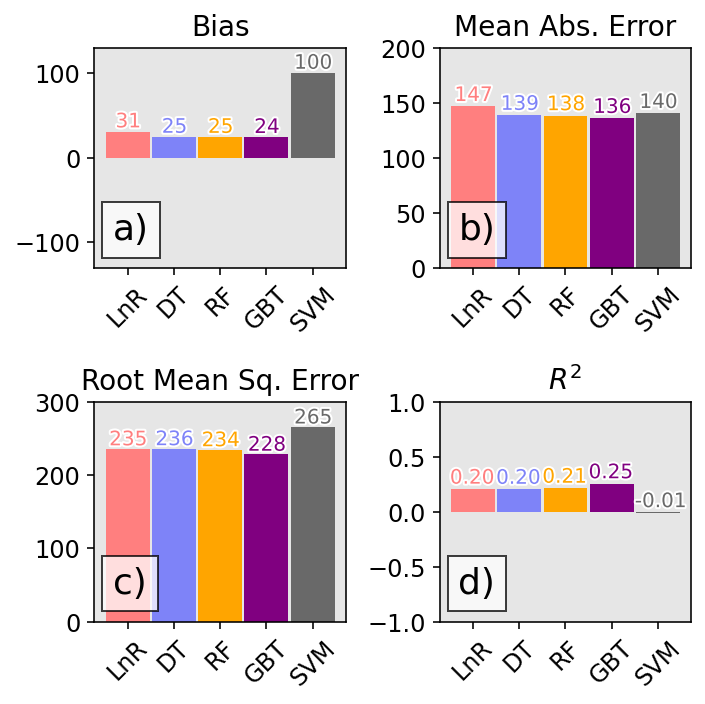

In [18]:
#some annotation helpers
import matplotlib.patheffects as path_effects
pe = [path_effects.withStroke(linewidth=2,
                             foreground="k")]
pe2 = [path_effects.withStroke(linewidth=2,
                             foreground="w")]
#make a 2 row, 2 column figure of size 5" by 5"
fig,axes = plt.subplots(2,2,figsize=(5,5))
#set facecolor to white so we can copy/paste it whereever
fig.set_facecolor('w')

#list of labels for the x-axis 
labels= ['LnR','DT','RF','GBT','SVM']

#loop over all trained models 
for i,model in enumerate(model_list):
    #get predictions 
    yhat = model.predict(X_validate)
    mae = get_mae(y_validate,yhat)
    rmse = get_rmse(y_validate,yhat)
    bias = get_bias(y_validate,yhat)
    r2 = get_r2(y_validate,yhat)
    
    ############### subplot 0,0: Bias ########################
    ax = axes[0,0]
    #put a bar at position i (from our loop)
    ax.bar(i,bias,width=0.95,color=colors[i])
    #make the annotation so we can see the numerical data on the plot 
    annotate = str(int(np.round(bias))).rjust(3, ' ')
    ax.text(i-0.4,bias+5,annotate,color=colors[i],path_effects=pe2)
    ##########################################################

    ####### subplot 0,1: Mean Absolute Error #################
    ax = axes[0,1]
    #put a bar at position i (from our loop)
    ax.bar(i,mae,width=0.95,color=colors[i])
    #make the annotation so we can see the numerical data on the plot 
    annotate = str(int(np.round(mae))).rjust(3, ' ')
    ax.text(i-0.4,mae+5,annotate,color=colors[i],path_effects=pe2)
    ##########################################################
    
    ####### subplot 1,0: Root Mean Squared Error #############
    ax = axes[1,0]
    ax.bar(i,rmse,width=0.95,color=colors[i])
    annotate = str(int(np.round(rmse))).rjust(3, ' ')
    ax.text(i-0.4,rmse+5,annotate,color=colors[i],path_effects=pe2)
    ##########################################################
    
    ####### subplot 1,1: Rsquared ###########################
    ax = axes[1,1]
    ax.bar(i,r2,width=0.95,color=colors[i])
    annotate = str(np.round(r2,2)).ljust(4, '0')
    ax.text(i-0.5,r2+0.05,annotate,color=colors[i],path_effects=pe2)
    ##########################################################
    

    

#cosmetic things: 
ax = axes[0,0]
ax.xaxis.set_ticks(np.arange(0,5))
ax.xaxis.set_ticklabels(labels,rotation=45)
ax.set_ylim([-130,130])
ax.set_title("Bias")
ax.text(0.075, 0.25, annotate_list[0], transform=ax.transAxes,fontsize=fs4,
verticalalignment='top', bbox=props)

ax = axes[0,1]
ax.set_ylim([0,200])
ax.xaxis.set_ticks(np.arange(0,5))
ax.xaxis.set_ticklabels(labels,rotation=45)
ax.set_title("Mean Abs. Error")
ax.text(0.075, 0.25, annotate_list[1], transform=ax.transAxes,fontsize=fs4,
verticalalignment='top', bbox=props)

ax = axes[1,0]
ax.set_ylim([0,300])
ax.xaxis.set_ticks(np.arange(0,5))
ax.xaxis.set_ticklabels(labels,rotation=45)
ax.set_title("Root Mean Sq. Error")
ax.text(0.075, 0.25, annotate_list[2], transform=ax.transAxes,fontsize=fs4,
verticalalignment='top', bbox=props)

ax = axes[1,1]
ax.set_ylim([-1,1])
ax.xaxis.set_ticks(np.arange(0,5))
ax.xaxis.set_ticklabels(labels,rotation=45)
ax.set_title("$R^{2}$")
ax.text(0.075, 0.25, annotate_list[3], transform=ax.transAxes,fontsize=fs4,
verticalalignment='top', bbox=props)
    
plt.tight_layout()

There ya go! You have successfully made a metric bar chart to compare the 5 ML regression models you trained. Like earlier in this notebook (the end of the classification task), I encourage you to extend this notebook to now include all predictors!